# Instalação de Pacotes

In [2]:
!pip install --quiet rdkit
!pip install --quiet ase
!pip install --quiet dscribe
!pip install --quiet optuna
!pip install --quiet requests
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


# Carregamento Pacotes


In [3]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt

import optuna

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Executando em: {device}")

2.5.0+cu121
Executando em: cpu


In [4]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

# Carregamento do Conjunto de Dados (QM9)

## Dropbox link (Download)

In [5]:
import os
import zipfile
import requests

# URL do arquivo no Dropbox com `?dl=1` para forçar o download direto
url = "https://www.dropbox.com/scl/fi/lbs52lc0av3eqi9zws3wp/QM9.zip?rlkey=925vtuebvf7kf9ifq9143d6az&dl=1"
zip_path = "QM9.zip"
qm9_folder = "QM9Data"

# Baixar o arquivo se ele não existir localmente
if not os.path.exists(zip_path):
    print("Baixando o arquivo QM9.zip...")
    response = requests.get(url, stream=True)
    with open(zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download concluído.")

# Criar a pasta de extração, se necessário
if not os.path.exists(qm9_folder):
    os.makedirs(qm9_folder)

# Extrair o conteúdo do arquivo zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(qm9_folder)

print(f"Dados salvos em: {qm9_folder}")


Baixando o arquivo QM9.zip...
Download concluído.
Dados salvos em: QM9Data


# Extração e Preparação dos Dados


In [6]:
with open(qm9_folder+"/dsgdb9nsd_075700.xyz") as file:
    for line in file:
        print(line)

16

gdb 75700	2.29421	2.10153	1.19281	1.5927	71.76	-0.2569	-0.021	0.2359	1002.3496	0.125963	-434.09168	-434.083979	-434.083035	-434.123886	28.894	

C	 0.0082723652	 1.4385040241	 0.0216304465	-0.368015

N	-0.0080626856	-0.0080486441	-0.0143324088	-0.128223

C	-0.0025221437	-0.7715337629	-1.1909538518	 0.388126

N	 0.0263387403	-0.3906951642	-2.3959782595	-0.532716

N	-0.0435539427	-2.1606959554	-0.8372214133	-0.113662

C	 1.1983737221	-2.6000297832	-0.1756188576	-0.242408

C	 0.0113061798	-2.2080435108	 0.6349537932	-0.162296

C	-0.0270216144	-0.7926214222	 1.1346516211	 0.42506

O	-0.0955434019	-0.3870203764	 2.2694066024	-0.371241

H	 0.9216696532	 1.8340504971	-0.4354195835	 0.141444

H	-0.8595819793	 1.8482562075	-0.5050019382	 0.146272

H	-0.0319704226	 1.7357251605	 1.0706204257	 0.173704

H	 0.0660884133	 0.6248858104	-2.4690959743	 0.222945

H	 1.4244948343	-3.6539669067	-0.2978095694	 0.14517

H	 2.0547706395	-1.9318987311	-0.1997156332	 0.140887

H	-0.5885282877	-2.9489560327

In [7]:
def load_qm9_xyz(file_path):
    """Load a single QM9.xyz file."""
    with open(file_path, 'r') as f:
        # Number of atoms
        natoms = int(f.readline())
        # Properties are in the second line
        properties = list(map(float, f.readline().split()[2:]))
        # Read atomic coordinates and types
        atoms = []
        coordinates = []
        # print(properties)
        for num_line, line in enumerate(f):
            # print(num_line, line)
            if num_line >= 0 and num_line < natoms:
                info = line.replace("*^","e").split()
                atoms.append(info[0])
                coordinates.append(list(map(float, info[1:-1])))

    return {
        "natoms": natoms,
        "atoms": atoms,
        "coordinates": np.array(coordinates),
        "properties": properties
    }

def load_qm9_dataset(directory_path, list_mols=[]):
    """Load the entire QM9 dataset from a directory containing .xyz files."""
    X = []
    Y = []
    S = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".xyz"):
            file_path = os.path.join(directory_path, file_name)
            molecule_data = load_qm9_xyz(file_path)
            if molecule_data['natoms'] in list_mols or len(list_mols)==0:
              X.append([molecule_data['atoms'], molecule_data['coordinates']])
              Y.append(molecule_data['properties'])
              S.append(molecule_data['natoms'])
    return X, Y, S

In [8]:
# Loading
# segundo parâmetro: lista com o tamanho das moléculas desejadas | [] para selecionar todas]
XYZ, Y, natoms = load_qm9_dataset(qm9_folder)
Y = np.array(Y)

samples =  len(XYZ)
print(f"Numero Moléculas: {samples}")
print(f"Primeira Molécula: {XYZ[0]}")
print(f"Propriedades Mol[0]: {Y[0]}")


Numero Moléculas: 133885
Primeira Molécula: [['O', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'], array([[ 0.02357102,  0.92573576,  1.58429548],
       [-0.02585037,  1.4160204 ,  0.47549997],
       [-1.37654544,  1.86495537, -0.08391578],
       [-1.43539921,  2.01547325, -1.47904061],
       [-0.91772959,  3.22378564, -1.97349621],
       [ 0.60376273,  3.28073209, -2.11732547],
       [ 1.09977905,  4.11315065, -2.84759721],
       [ 1.48628276,  2.33617496, -1.38128172],
       [ 1.22673904,  1.56748784, -0.31245123],
       [-2.10286898,  1.09701515,  0.19586179],
       [-1.66530212,  2.7938882 ,  0.43591959],
       [-1.33327147,  3.37596609, -2.97335656],
       [-1.23063074,  4.08149739, -1.35466783],
       [ 2.5047307 ,  2.37056364, -1.76048904],
       [ 2.04452154,  1.00756912,  0.1346948 ]])]
Propriedades Mol[0]: [ 3.14044000e+00  1.31863000e+00  9.79600000e-01  5.88700000e-01
  7.08500000e+01 -2.53700000e-01 -1.01500000e-01  1.52200000e-01
  1.1

In [9]:
natoms = np.array(natoms)
min_atoms = np.min(natoms)
max_atoms = np.max(natoms)
print(f"Menor Molécula: {min_atoms}")
print(f"Maior Molécula: {max_atoms}")

Menor Molécula: 3
Maior Molécula: 29


# Geração dos Descritores (DScribe)

- Matriz de Coulomb (CM)
- Atom-centered Symmetry Functions (ACSF)
- Smooth Overlap of Atomic Positions (SOAP)
- Many-body Tensor Representation (MBTR)


In [10]:
from ase import Atoms

In [11]:
from dscribe.descriptors import CoulombMatrix, ACSF, SOAP, MBTR

mols = [Atoms(positions=coordinates, symbols=symbols) for (symbols, coordinates) in XYZ]

# informa o tipo de descritor selecionado
descriptor = 'CM' # CM, SOAP, MBTR, ACSF

## Matriz de Coulomb (CM)

In [12]:
if descriptor == 'CM':
    cm = CoulombMatrix(n_atoms_max=max_atoms, permutation="eigenspectrum")
    X = cm.create(mols)
    print(X.shape)

(133885, 29)


## Atom-centered Symmetry Functions (ACSF)

---



In [13]:
if descriptor == 'ACSF':
    acsf = ACSF(
        species=["H", "C", "O", "N", "F"],
        r_cut=6.0,
        g2_params=[[1, 1], [1, 2], [1, 3]],
        g4_params=[[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]],
    )
    centers = samples*[[0]]
    X = acsf.create(mols, centers).reshape([samples,-1])
    print(X.shape)

## Smooth Overlap of Atomic Positions (SOAP)

In [14]:
if descriptor == 'SOAP':
    soap = SOAP(
        species=["H", "C", "O", "N", "F"],
        periodic=False,
        r_cut=6.0,
        n_max=8,
        l_max=6,
    )

    centers = samples*[[0]]
    X = soap.create(mols, centers).reshape([samples, -1])
    print(X.shape)

## Many-body Tensor Representation (MBTR)

In [15]:
if descriptor == 'MBTR':
  mbtr = MBTR(
      species=["H", "C", "O", "N", "F"],
      geometry={"function": "distance"},
      grid={"min": 0.4, "max": 8, "sigma": 0.1, "n": 100},
      periodic=False,
      sparse=False,
      normalization="l2",
  )

  X = mbtr.create(mols)
  print(X.shape)

# Preparação dos Dados


In [16]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)

**Q9 Dataset: Propriedades**

0. Rotational constant A: GHz
1. Rotational constant B: GHz
2. Rotational constant C: GHz
3. Dipole moment (μ): Debye (D)
4. Isotropic polarizability (α): atomic units (a.u.)
5. Energy of HOMO (ϵHOMO): Hartree (Ha)
6. Energy of LUMO (ϵLUMO): Hartree (Ha)
7. Gap (ϵgap): Hartree (Ha)
8. Electronic spatial extent: atomic units (a.u.)
9. Zero point vibrational energy (zpve): Hartree (Ha)
10. Internal energy at 0 K (U0): Hartree (Ha)
11. Internal energy at 298.15 K (U): Hartree (Ha)
12. Enthalpy at 298.15 K (H): Hartree (Ha)
13. Free energy at 298.15 K (G): Hartree (Ha)
15. Heat capacity at 298.15 K (Cv): cal/mol·K



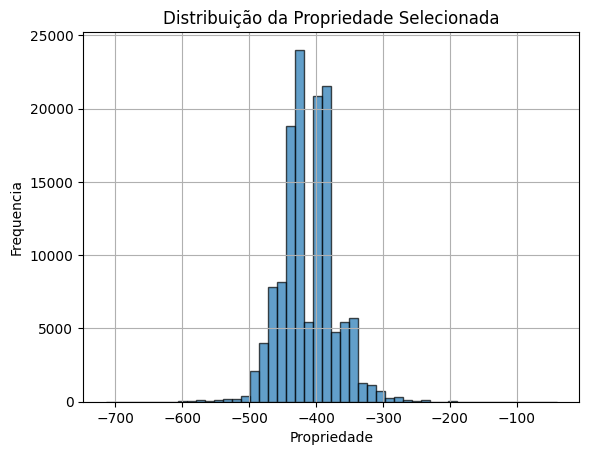

In [17]:
# Seleção da propriedade alvo
att_alvo = 10 # 15 propriedades [0-14]
Ys = Y[:,att_alvo].reshape(-1,1)
plt.hist(Y[:,att_alvo], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Propriedade')
plt.ylabel('Frequencia')
plt.title('Distribuição da Propriedade Selecionada')
plt.grid(True)
plt.show()


In [18]:
# Normalização, Split, DataLoader
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xn = scaler.fit_transform(X)

In [19]:
class Data(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]).float(), torch.from_numpy(self.targets[idx]).float()

dataset = Data(Xn,Ys)

In [20]:
batch_size = 256

train_len = int(0.8 * len(dataset))
val_len = int(0.1 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Rede Neural


## Modelo (Pytorch)

In [37]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, layers, lr=0.001):
        super(MLP, self).__init__()
        all_layers = []
        prev_dim = input_dim

        # Camadas ocultas
        for layer_dim in layers:
            all_layers.append(nn.Linear(prev_dim, layer_dim))
            all_layers.append(nn.ReLU())
            prev_dim = layer_dim

        # Camada de saída (ativação linear - regressão)
        all_layers.append(nn.Linear(prev_dim, output_dim))

        # Combinando as camadas
        self.layers = nn.Sequential(*all_layers)

        self.criterion = nn.L1Loss() #nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        return self.layers(x)

    def train_model(self, dataloader):
        self.train()
        total_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            self.optimizer.zero_grad()
            outputs = self(batch_x)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def validate_model(self, dataloader):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = self(batch_x)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def test_model(self, dataloader):
        self.eval()
        predictions = []
        targets = []
        total_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = self(batch_x)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
                predictions.extend(outputs.cpu().tolist())
                targets.extend(batch_y.cpu().tolist())
        return predictions, targets, total_loss / len(dataloader)

    def predict(self, dataloader):
        self.eval()
        predictions = []
        with torch.no_grad():
            for batch_x, _ in dataloader:
                batch_x = batch_x.to(device)
                outputs = self(batch_x)
                predictions.extend(outputs.cpu().tolist())
        return predictions

In [38]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


## Otimizando os Hiperparâmetros

### Função Objetivo Optuna

In [39]:
def objective(trial):
    early_stopping = EarlyStopping(patience=7, verbose=False)
    # lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    lr = 0.001
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_l{i+1}', 20, 400, 20))

    model = MLP(input_dim=X.shape[1], output_dim=1, layers=layers, lr=lr).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(2000): # máximo épocas
        train_loss = model.train_model(train_loader)
        val_loss = model.validate_model(val_loader)
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            break
    return val_loss


### Otimização

**Cuidado:** O custo computacional pode ser elevado

In [40]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Número de tentativas: ', len(study.trials))
print('Melhor Resultado:')
trial = study.best_trial

print('MAE: ', trial.value)
print('Hiperparâmetros: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-11-08 02:13:46,025] A new study created in memory with name: no-name-e28927ec-5607-4b45-95c4-85c775bc7064
<ipython-input-39-1ab0a2b2131c>:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  layers.append(trial.suggest_int(f'n_units_l{i+1}', 20, 400, 20))
[I 2024-11-08 02:15:51,025] Trial 0 finished with value: 0.6483489544886463 and parameters: {'n_layers': 2, 'n_units_l1': 300, 'n_units_l2': 280}. Best is trial 0 with value: 0.6483489544886463.
[I 2024-11-08 02:17:27,563] Trial 1 finished with value: 0.45926318528517235 and parameters: {'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 120}. Best is trial 1 with value: 0.45926318528517235.
[I 2024-11-08 02:18:40,540] Trial 2 finished with value: 0.6801774670492928 and parameters: {'n_layers': 2, 'n_units_l1': 160, 'n_units_l2': 200}. Best is trial 1 with value: 0.45926318528517235.
[I 2024-11-08 02:20:23,168] Trial 3 finished with value: 0.72299360891558

Número de tentativas:  10
Melhor Resultado:
MAE:  0.1434394601943358
Hiperparâmetros: 
    n_layers: 1
    n_units_l1: 120


## Treinamento

Época 10/1000, Train Loss: 6.2481, Validation Loss: 5.1628
Época 20/1000, Train Loss: 0.3624, Validation Loss: 0.4206
Época 30/1000, Train Loss: 0.2025, Validation Loss: 0.1855
Época 40/1000, Train Loss: 0.1665, Validation Loss: 0.2299
Época 50/1000, Train Loss: 0.1558, Validation Loss: 0.1319
Época 60/1000, Train Loss: 0.1568, Validation Loss: 0.1444
Early stopping


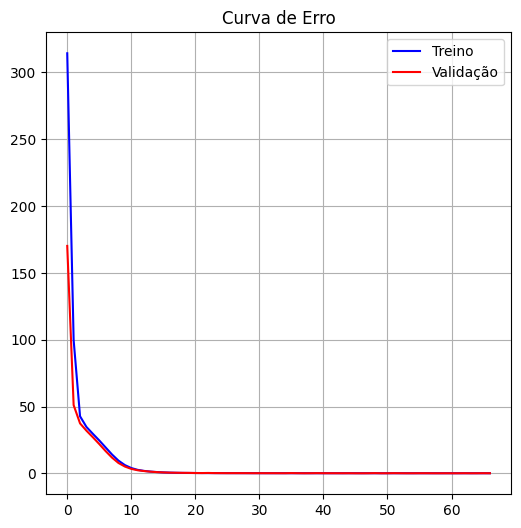

In [41]:
num_epochs = 1000
learning_rate = 0.001
# Definição do Modelo
model = MLP(input_dim=X.shape[1], output_dim=1, layers=[180], lr=learning_rate).to(device)

# Early Stop
early_stopping = EarlyStopping(patience=20, verbose=False)

tloss = []
vloss = []
for epoch in range(num_epochs):
    train_loss = model.train_model(train_loader)
    val_loss = model.validate_model(val_loader)
    tloss.append(train_loss)
    vloss.append(val_loss)
    if (epoch+1) % 10 == 0:
        print(f"Época {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Curva de Erro")
ax.plot(tloss,'blue', label='Treino')
ax.plot(vloss,'red', label='Validação')
ax.legend()
ax.grid(True)
plt.show()


Erro de predição (MAE) no conjunto de teste: 0.15192239942415706


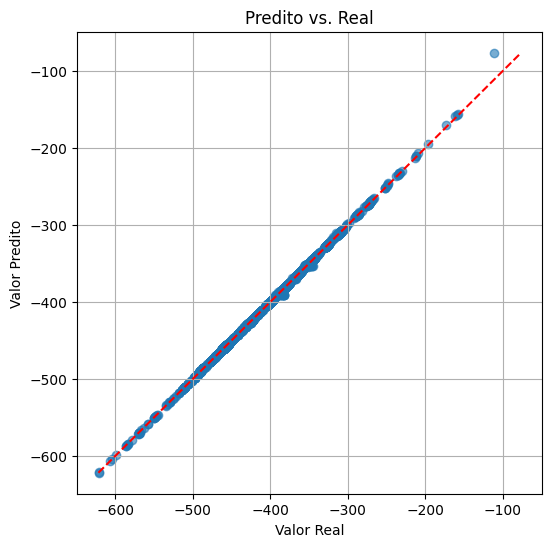

In [42]:
Yp, Yt, loss_test = model.test_model(test_loader)

plt.figure(figsize=(6, 6))
plt.scatter(Yp, Yt, alpha=0.6)

max_val = max(max(Yt), max(Yp))
min_val = min(min(Yt), min(Yp))
plt.plot([min_val, max_val], [min_val, max_val], 'r', linestyle='--')

plt.xlabel('Valor Real')
plt.ylabel('Valor Predito')
plt.title('Predito vs. Real')
plt.grid(True)

print(f"Erro de predição (MAE) no conjunto de teste: {loss_test}")

plt.show()



# Explicação com Shap

In [49]:
from chemXAI import Shap

In [50]:
# Inicializa a classe Shap com o modelo e DataLoaders
shap_explainer = Shap(model, train_loader, test_loader, device)

# Gera e exibe uma explicação local para a primeira instância no batch de teste
local_explanation = shap_explainer.local_explanation(0)

# Gera e exibe a explicação global
global_explanation = shap_explainer.global_explanation()

Background shape: (256, 29)
Test data shape: (256, 29)


  0%|          | 0/256 [00:00<?, ?it/s]

Local SHAP values shape: (29,)
Local Explanation for Instance 0
Global SHAP values shape: (29,)
Global Feature Importance


In [45]:
print(local_explanation)

    Feature Index  SHAP Value
0              11    0.101039
1              15    0.037367
2              14    0.021114
3              16    0.017514
4              13    0.010954
5              12    0.008795
6              27    0.000000
7              26    0.000000
8              22    0.000000
9              18    0.000000
10             28    0.000000
11              9    0.000000
12             25   -0.001596
13             23   -0.003253
14             10   -0.003275
15             21   -0.005699
16             20   -0.010531
17             24   -0.010696
18             19   -0.018066
19             17   -0.098737
20              6   -0.661669
21              7   -0.733076
22              8   -1.286436
23              0   -2.004534
24              5   -2.083654
25              4   -5.671738
26              2  -10.643402
27              3  -11.446736
28              1  -28.761397


In [46]:
print(global_explanation)

    Feature Index  Importance
0               0   11.795541
1               1    7.614298
2               2    7.213458
3               3    5.139980
4               4    3.223439
5               5    2.533395
6               6    2.148023
7               8    1.783673
8               7    1.746498
9              11    0.140051
10             13    0.120605
11             14    0.108951
12             12    0.106631
13             10    0.073090
14             15    0.050622
15             16    0.049540
16             19    0.040161
17             17    0.028919
18             20    0.024302
19              9    0.022307
20             22    0.018260
21             21    0.017510
22             23    0.012825
23             18    0.011694
24             24    0.008307
25             25    0.005064
26             26    0.003091
27             27    0.000000
28             28    0.000000


# Experimentos (Sugestões)






1. Generalizar para todos os Descritores
2. Fazer a adaptação para o LIME
